# Antimikrobiyal Direnç Tahmin Modeli
Ülke bazında 2025-2030 direnç tahmini

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## 1. Veri Yükleme ve Hazırlama

In [2]:
# Veriyi yükle
ecoli_df = pd.read_csv('ecoli.csv')

# Sadece direnç yüzdesi verilerini filtrele
resistance_df = ecoli_df[ecoli_df['Indicator'] == 'R - resistant isolates, percentage  '].copy()

# Gerekli sütunları seç
simplified_df = resistance_df[['Time', 'RegionName', 'Population', 'NumValue']].copy()
simplified_df.columns = ['Year', 'Country', 'Bacteria_Antibiotic', 'Resistance_Percentage']

# Bakteri ve antibiyotik bilgisini ayır
simplified_df[['Bacteria', 'Antibiotic']] = simplified_df['Bacteria_Antibiotic'].str.split('|', expand=True)
simplified_df = simplified_df[['Year', 'Country', 'Bacteria', 'Antibiotic', 'Resistance_Percentage']]

# Eksik değerleri temizle
simplified_df['Resistance_Percentage'] = pd.to_numeric(simplified_df['Resistance_Percentage'], errors='coerce')

# Yıl ve ülke bazında ortalama direnç
final_df = simplified_df.groupby(['Year', 'Country'])['Resistance_Percentage'].mean().reset_index()
final_df.columns = ['Year', 'Country', 'Avg_Resistance_%']
final_df['Avg_Resistance_%'] = final_df['Avg_Resistance_%'].round(2)

# Eksik verileri temizle
df_clean = final_df.dropna().copy()

print(f"✓ Veri hazır: {len(df_clean)} satır, {df_clean['Country'].nunique()} ülke, {df_clean['Year'].nunique()} yıl")

✓ Veri hazır: 717 satır, 30 ülke, 25 yıl


## 2. Ülke Bazında Model Oluşturma

In [3]:
# Her ülke için ayrı polynomial regression modeli
country_models = {}
country_trends = {}

for country in df_clean['Country'].unique():
    country_data = df_clean[df_clean['Country'] == country].sort_values('Year')
    
    if len(country_data) < 3:
        continue
    
    X_country = country_data[['Year']].values
    y_country = country_data['Avg_Resistance_%'].values
    
    # Polynomial Regression (degree=2)
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    model.fit(X_country, y_country)
    
    country_models[country] = model
    country_trends[country] = {
        'years': country_data['Year'].values,
        'values': country_data['Avg_Resistance_%'].values
    }

print(f"✓ {len(country_models)} ülke için model oluşturuldu")

✓ 30 ülke için model oluşturuldu


## 3. Gelecek Tahminleri (2025-2030)

In [4]:
# Gelecek tahminleri
future_predictions = []

for country, model in country_models.items():
    for year in range(2025, 2031):
        pred = model.predict([[year]])[0]
        pred = max(0, pred)  # Negatif değerleri sıfırla
        future_predictions.append({
            'Year': year,
            'Country': country,
            'Predicted_Resistance_%': round(pred, 2)
        })

future_df = pd.DataFrame(future_predictions)

# Dosyaya kaydet
future_df.to_csv('future_predictions_2025_2030.csv', index=False)
print(f"✓ {len(future_df)} tahmin yapıldı ve kaydedildi")

✓ 180 tahmin yapıldı ve kaydedildi


## 4. Model Performansı

In [5]:
# Model performansını değerlendir
scores = []

for country in country_models.keys():
    country_data = df_clean[df_clean['Country'] == country].sort_values('Year')
    
    if len(country_data) < 5:
        continue
    
    X_country = country_data[['Year']].values
    y_country = country_data['Avg_Resistance_%'].values
    y_pred = country_models[country].predict(X_country)
    
    mae = mean_absolute_error(y_country, y_pred)
    r2 = r2_score(y_country, y_pred)
    
    scores.append({
        'Country': country,
        'MAE': round(mae, 2),
        'R²': round(r2, 3)
    })

scores_df = pd.DataFrame(scores).sort_values('R²', ascending=False)

print("📊 Model Performansı (En İyi 10):")
print(scores_df.head(10).to_string(index=False))
print(f"\n📈 Ortalama: MAE = {scores_df['MAE'].mean():.2f}, R² = {scores_df['R²'].mean():.3f}")

📊 Model Performansı (En İyi 10):
  Country  MAE    R²
 Slovakia 1.78 0.952
  Croatia 1.58 0.947
   Greece 1.75 0.933
Lithuania 1.55 0.911
   Cyprus 1.74 0.901
  Denmark 1.47 0.822
   Poland 2.97 0.747
  Hungary 2.27 0.736
   Latvia 2.73 0.733
 Bulgaria 3.23 0.720

📈 Ortalama: MAE = 2.14, R² = 0.525
  Country  MAE    R²
 Slovakia 1.78 0.952
  Croatia 1.58 0.947
   Greece 1.75 0.933
Lithuania 1.55 0.911
   Cyprus 1.74 0.901
  Denmark 1.47 0.822
   Poland 2.97 0.747
  Hungary 2.27 0.736
   Latvia 2.73 0.733
 Bulgaria 3.23 0.720

📈 Ortalama: MAE = 2.14, R² = 0.525


## 5. Görselleştirme - En Riskli Ülkeler

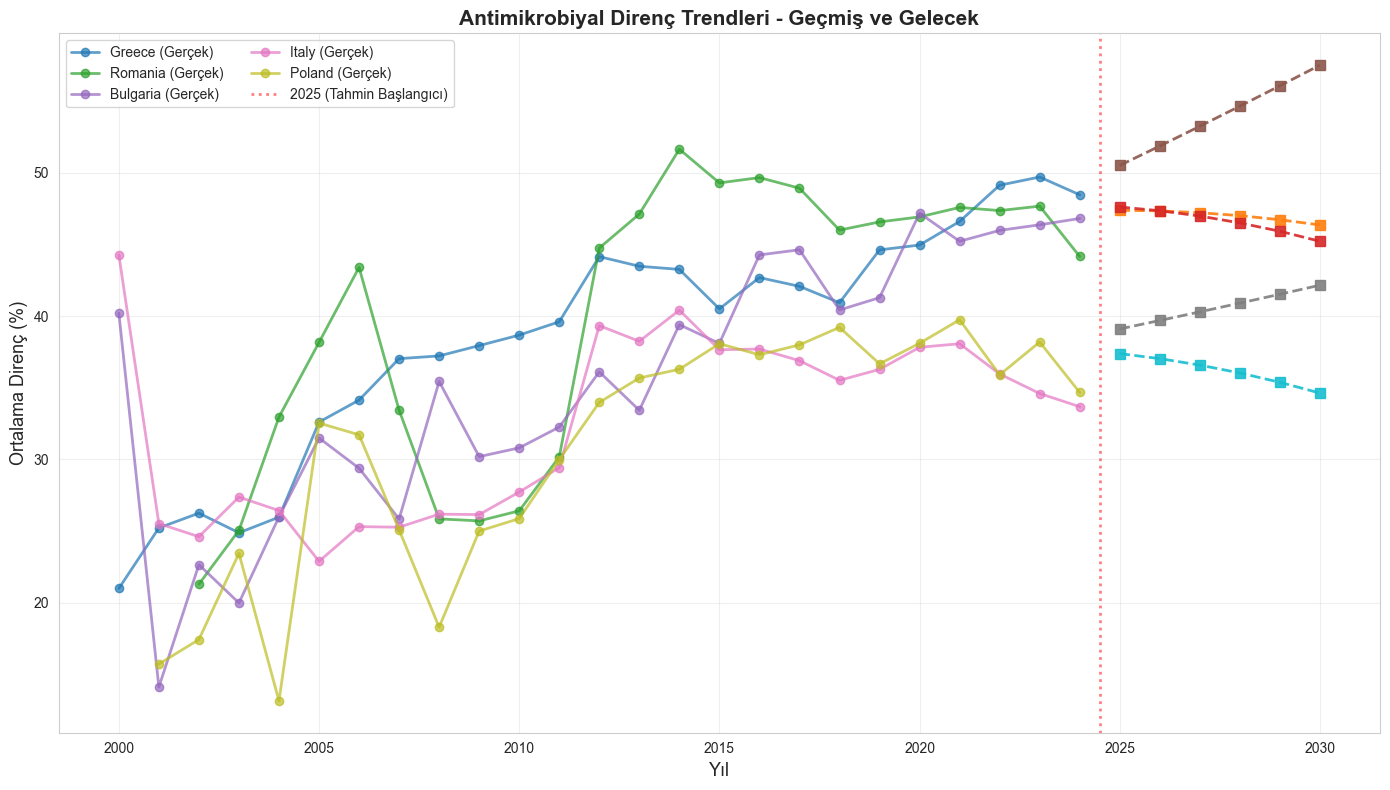

In [6]:
# En yüksek ortalama dirençli 5 ülke
top_countries = ['Greece', 'Romania', 'Bulgaria', 'Italy', 'Poland']

plt.figure(figsize=(14, 8))

for country in top_countries:
    if country not in country_models:
        continue
    
    # Geçmiş veri
    hist_years = country_trends[country]['years']
    hist_values = country_trends[country]['values']
    
    # Gelecek tahmini
    future_data = future_df[future_df['Country'] == country]
    future_years = future_data['Year'].values
    future_values = future_data['Predicted_Resistance_%'].values
    
    # Çizim
    plt.plot(hist_years, hist_values, 'o-', linewidth=2, markersize=6, 
             label=f'{country} (Gerçek)', alpha=0.7)
    plt.plot(future_years, future_values, 's--', linewidth=2, markersize=7, alpha=0.9)

plt.axvline(x=2024.5, color='red', linestyle=':', linewidth=2, alpha=0.5, 
            label='2025 (Tahmin Başlangıcı)')
plt.title('Antimikrobiyal Direnç Trendleri - Geçmiş ve Gelecek', fontsize=15, fontweight='bold')
plt.xlabel('Yıl', fontsize=13)
plt.ylabel('Ortalama Direnç (%)', fontsize=13)
plt.legend(loc='best', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. 2030 Risk Analizi

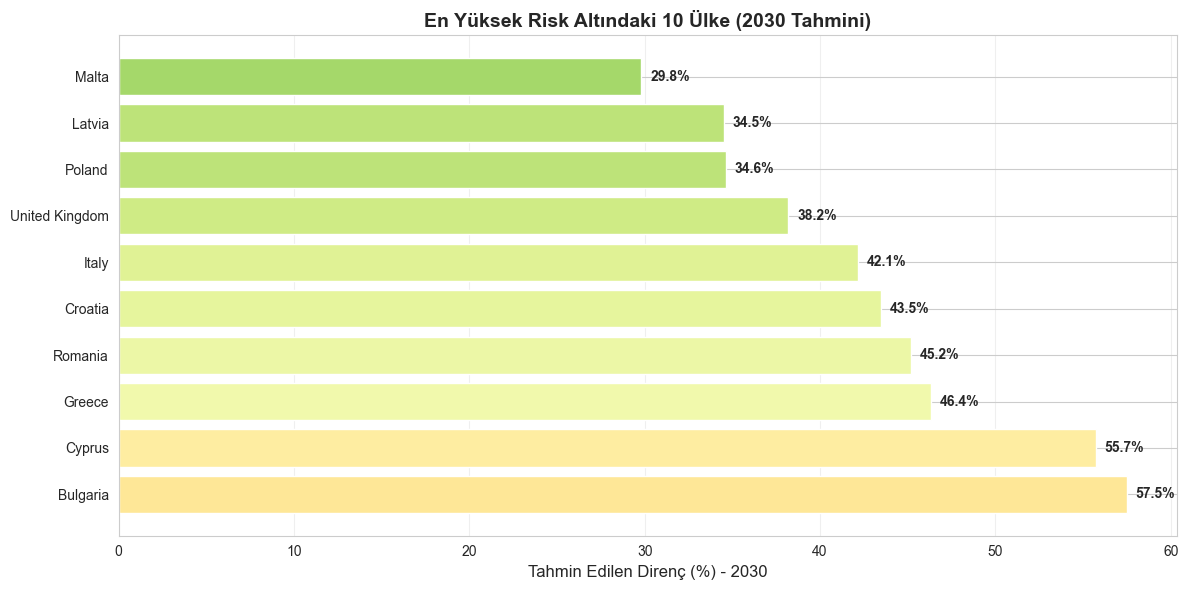


⚠️ EN YÜKSEK RİSK (2030):
   Bulgaria: 57.49%
   Cyprus: 55.73%
   Greece: 46.35%
   Romania: 45.21%
   Croatia: 43.50%
   Italy: 42.15%
   United Kingdom: 38.19%
   Poland: 34.63%
   Latvia: 34.52%
   Malta: 29.82%


In [7]:
# 2030 yılı için en yüksek riskli ülkeler
risk_2030 = future_df[future_df['Year'] == 2030].sort_values(
    'Predicted_Resistance_%', ascending=False
).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(risk_2030['Country'], risk_2030['Predicted_Resistance_%'], 
                color=plt.cm.RdYlGn_r(risk_2030['Predicted_Resistance_%']/100))
plt.xlabel('Tahmin Edilen Direnç (%) - 2030', fontsize=12)
plt.title('En Yüksek Risk Altındaki 10 Ülke (2030 Tahmini)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(risk_2030.iterrows()):
    plt.text(row['Predicted_Resistance_%'] + 0.5, i, f"{row['Predicted_Resistance_%']:.1f}%", 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ EN YÜKSEK RİSK (2030):")
for idx, row in risk_2030.iterrows():
    print(f"   {row['Country']}: {row['Predicted_Resistance_%']:.2f}%")

## 7. Örnek Tahminler

In [8]:
# Seçili ülkeler için detaylı tahminler
example_countries = ['Greece', 'Romania', 'Bulgaria', 'Italy', 'Poland']

print("🔮 2025-2030 Tahminleri:\n")
for country in example_countries:
    if country in country_models:
        country_future = future_df[future_df['Country'] == country]
        print(f"📍 {country}:")
        for _, row in country_future.iterrows():
            print(f"   {row['Year']}: {row['Predicted_Resistance_%']:.2f}%")
        print()

🔮 2025-2030 Tahminleri:

📍 Greece:
   2025: 47.37%
   2026: 47.33%
   2027: 47.20%
   2028: 47.00%
   2029: 46.71%
   2030: 46.35%

📍 Romania:
   2025: 47.60%
   2026: 47.34%
   2027: 46.97%
   2028: 46.49%
   2029: 45.91%
   2030: 45.21%

📍 Bulgaria:
   2025: 50.50%
   2026: 51.85%
   2027: 53.23%
   2028: 54.63%
   2029: 56.05%
   2030: 57.49%

📍 Italy:
   2025: 39.10%
   2026: 39.69%
   2027: 40.29%
   2028: 40.90%
   2029: 41.52%
   2030: 42.15%

📍 Poland:
   2025: 37.38%
   2026: 37.03%
   2027: 36.58%
   2028: 36.03%
   2029: 35.38%
   2030: 34.63%

